In [1]:
!pip install boto3
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.5 MB/s eta 0:00:00


In [2]:
import boto3
import pandas as pd
from io import StringIO
from io import BytesIO
import time
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import os

# Set AWS credentials using environment variables
os.environ['AWS_ACCESS_KEY_ID'] = ...  # Replace with your access key
os.environ['AWS_SECRET_ACCESS_KEY'] = ...  # Replace with your secret key
os.environ['AWS_DEFAULT_REGION'] = ...  # Replace with your region, e.g., 'us-east-1'

In [3]:
# Set up the S3 client
s3_client = boto3.client('s3')

# Define the bucket name and file key
bucket_name = 'beamdata-pocketride'
file_key = 'New York Data/10%_nyc_sample.parquet'

# Step 1: Start the timer
start_time = time.time()

# Step 2: Read the CSV file from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Check if the file was fetched successfully
if response.get("ResponseMetadata", {}).get("HTTPStatusCode") == 200:
    # Load the Parquet content into a pandas DataFrame using BytesIO
    # BytesIO creates a file-like object in memory that supports 'seek'
    data = BytesIO(response['Body'].read()) # Use BytesIO to wrap the data
    df = pd.read_parquet(data)

    # Step 3: Stop the timer
    end_time = time.time()

    # Calculate the total time taken
    time_taken = end_time - start_time

    # Display the DataFrame and the time taken
    df.head()
    print(f"\nTime taken to read the file from S3: {time_taken:.2f} seconds")
else:
    print("Failed to fetch the file from S3.")


Time taken to read the file from S3: 63.79 seconds


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652849 entries, 0 to 23652848
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int32         
 8   DOLocationID          int32         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [42]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'year_month'],
      dtype='object')

# Functions for z-score and IQR

In [61]:
def analyze_column(df, column_name, z_threshold=3, iqr_factor=1.5):
    from scipy import stats
    import numpy as np

    # Drop null values
    column_data = df[column_name].dropna()

    # Handle negative or zero values by applying a shift
    min_value = column_data.min()
    if min_value <= 0:
        shift = abs(min_value) + 1  # Add a constant to make all values positive
        column_data = column_data + shift
    else:
        shift = 0  # No shift needed

    # Calculate original skewness
    original_skewness = column_data.skew()

    # Apply log transformation
    column_data_log = np.log1p(column_data)  # Handles positive values safely

    # Calculate log skewness
    log_skewness = column_data_log.skew()

    # Calculate z-scores for log-transformed column
    z_scores_log = stats.zscore(column_data_log)

    # Calculate IQR for log-transformed column
    Q1 = column_data_log.quantile(0.25)
    Q3 = column_data_log.quantile(0.75)
    IQR = Q3 - Q1

    # Determine bounds for outliers
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    # Flag Z-score and IQR outliers
    z_outliers = np.abs(z_scores_log) > z_threshold
    iqr_outliers = (column_data_log < lower_bound) | (column_data_log > upper_bound)

    # Calculate confidence scores
    z_confidence = np.clip(np.abs(z_scores_log) / z_threshold, 0, 1)
    iqr_confidence = np.clip(
        np.where(column_data_log < lower_bound, (lower_bound - column_data_log) / IQR,
                 np.where(column_data_log > upper_bound, (column_data_log - upper_bound) / IQR, 0)),
        0, 1
    )

    # Combined confidence score
    combined_confidence = (z_confidence + iqr_confidence) / 2

    # Add new columns to the DataFrame
    df[f'IQR_{column_name}'] = iqr_outliers
    df[f'Z_OUTLIER_{column_name}'] = z_outliers
    df[f'CONFIDENCE_{column_name}'] = combined_confidence
    df[f'Z_LOG_SCORE_{column_name}'] = z_scores_log

    return original_skewness, log_skewness

def plot_histograms(df, column_name, original_skewness, log_skewness):
    column_data = df[column_name].dropna()
    column_data_log = np.log1p(column_data)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=50, color='blue', alpha=0.7)
    plt.title(f'Original {column_name} Histogram')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(column_data_log, bins=50, color='green', alpha=0.7)
    plt.title(f'Log-transformed {column_name} Histogram')
    plt.xlabel(f'Log({column_name})')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print(f"Original Skewness of {column_name}: {original_skewness}")
    print(f"Log-transformed Skewness of {column_name}: {log_skewness}")



In [62]:
# Drop rows where both 'trip_miles' and 'trip_time', and 'base_passenger_fare' and are null
df_cleaned = df.dropna(subset=['trip_miles', 'trip_time', 'base_passenger_fare'], how='all')

# Trip Miles

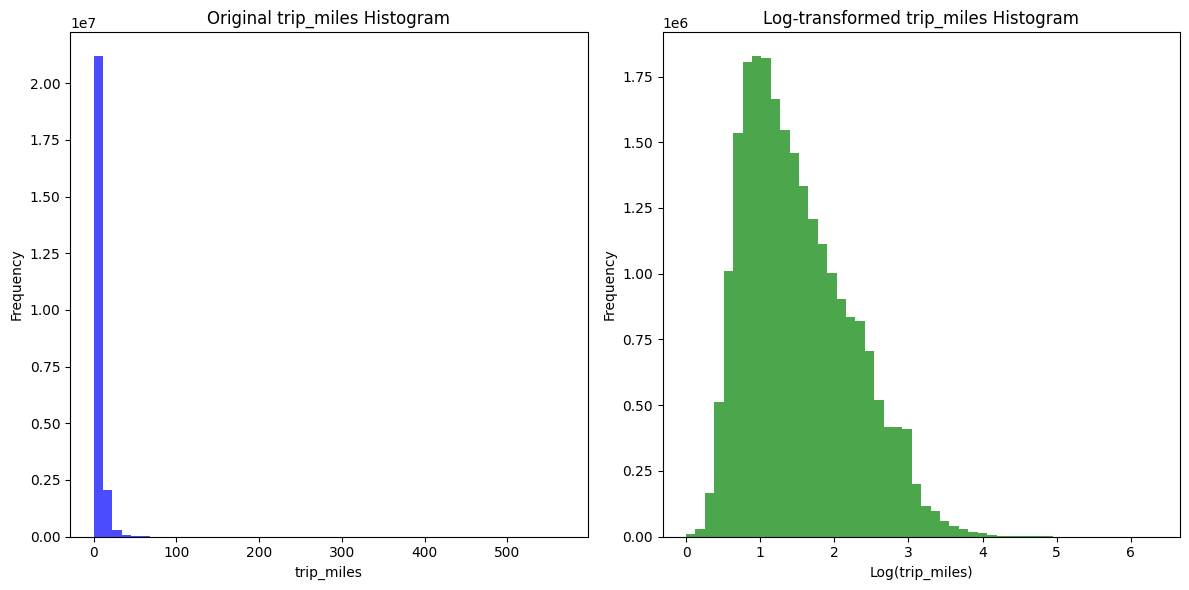

Original Skewness of trip_miles: 4.383119286694247
Log-transformed Skewness of trip_miles: 0.8737315756324678


In [63]:
# Example usage
# original_skewness, log_skewness = analyze_column(df, 'trip_miles')
# plot_histograms(df, 'trip_miles', original_skewness, log_skewness)
original_skewness, log_skewness = analyze_column(df_cleaned, 'trip_miles')
plot_histograms(df_cleaned, 'trip_miles', original_skewness, log_skewness)

# Trip Time

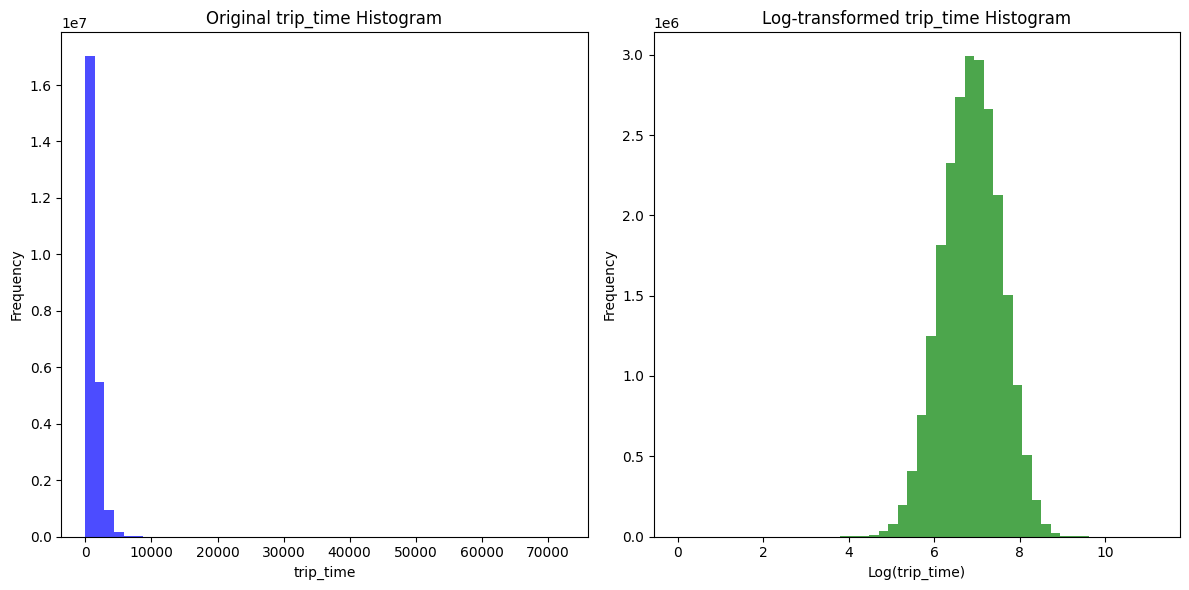

Original Skewness of trip_time: 2.29208858297289
Log-transformed Skewness of trip_time: -0.09447009527366639


In [64]:
# Example usage
original_skewness, log_skewness = analyze_column(df_cleaned, 'trip_time')
plot_histograms(df_cleaned, 'trip_time', original_skewness, log_skewness)

In [65]:
df_cleaned['base_passenger_fare'].describe()

,base_passenger_fare
count,2.365285e+07
mean,2.523767e+01
std,2.168180e+01
min,-1.282400e+02
25%,1.205000e+01
50%,1.892000e+01
75%,3.057000e+01
max,3.507110e+03


In [10]:
column_data = df_cleaned['base_passenger_fare'].dropna()

In [11]:
original_skewness = column_data.skew()

In [20]:
# Find all values equal to zero
zeros = column_data == 0

print("Boolean Series indicating zeros:")
print(zeros)

# Get the indices of zero values
zero_indices = column_data[zeros].index  # Use boolean indexing
print("\nIndices of zero values:")
print(zero_indices)

Boolean Series indicating zeros:
0           False
1           False
2           False
3           False
4           False
            ...  
23652844    False
23652845    False
23652846    False
23652847    False
23652848    False
Name: base_passenger_fare, Length: 23652849, dtype: bool

Indices of zero values:
Index([    8135,    79250,    80401,   754793,   832961,   860026,  1111720,
        1388177,  2018208,  2039025,
       ...
       21837347, 21848801, 22520630, 22640424, 22641480, 22736590, 22813962,
       22818784, 22950574, 23184961],
      dtype='int64', length=1278)


In [28]:
column_data[zero_indices]

,base_passenger_fare
8135,0.0
79250,0.0
80401,0.0
754793,0.0
832961,0.0
...,...
22736590,0.0
22813962,0.0
22818784,0.0
22950574,0.0


In [30]:
type(zero_indices)

pandas.core.indexes.base.Index

In [36]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652849 entries, 0 to 23652848
Data columns (total 33 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   hvfhs_license_num       object        
 1   dispatching_base_num    object        
 2   originating_base_num    object        
 3   request_datetime        datetime64[us]
 4   on_scene_datetime       datetime64[us]
 5   pickup_datetime         datetime64[us]
 6   dropoff_datetime        datetime64[us]
 7   PULocationID            int32         
 8   DOLocationID            int32         
 9   trip_miles              float64       
 10  trip_time               int64         
 11  base_passenger_fare     float64       
 12  tolls                   float64       
 13  bcf                     float64       
 14  sales_tax               float64       
 15  congestion_surcharge    float64       
 16  airport_fee             float64       
 17  tips                    float64       
 18  

In [45]:
df_cleaned.loc[zero_indices][['tolls','base_passenger_fare','tips','airport_fee','driver_pay','trip_miles', 'trip_time']]

,tolls,base_passenger_fare,tips,airport_fee,driver_pay,trip_miles,trip_time
8135,0.0,0.0,0.0,0.0,5.66,1.03,298
79250,0.0,0.0,0.0,0.0,11.12,1.69,724
80401,0.0,0.0,0.0,0.0,11.62,2.90,767
754793,0.0,0.0,0.0,0.0,35.79,10.85,2290
832961,0.0,0.0,0.0,0.0,10.06,2.03,783
...,...,...,...,...,...,...,...
22736590,0.0,0.0,0.0,0.0,13.05,2.97,927
22813962,0.0,0.0,0.0,0.0,14.51,2.17,1190
22818784,0.0,0.0,0.0,0.0,23.44,5.52,1441
22950574,0.0,0.0,0.0,0.0,5.58,1.27,396


In [40]:
# Find all negative values
negatives = column_data < 0

print("Boolean Series indicating negatives:")
print(negatives)

# Get the indices of zero values
negative_indices = column_data[negatives].index  # Use boolean indexing
print("\nIndices of negative values:")
print(negative_indices)

Boolean Series indicating negatives:
0           False
1           False
2           False
3           False
4           False
            ...  
23652844    False
23652845    False
23652846    False
23652847    False
23652848    False
Name: base_passenger_fare, Length: 23652849, dtype: bool

Indices of negative values:
Index([    4019,     9443,    14032,    19388,    23412,    27775,    41517,
          48166,    48750,    50919,
       ...
       23439724, 23458237, 23476429, 23480418, 23505617, 23520953, 23579900,
       23598755, 23606995, 23628012],
      dtype='int64', length=2645)


In [44]:
df_cleaned.loc[negative_indices][['tolls','base_passenger_fare','tips','airport_fee','driver_pay','trip_miles', 'trip_time']]

,tolls,base_passenger_fare,tips,airport_fee,driver_pay,trip_miles,trip_time
4019,0.0,-2.07,0.00,0.0,20.66,2.62,1832
9443,0.0,-6.53,3.19,0.0,0.19,15.13,1871
14032,0.0,-7.53,0.00,0.0,49.21,17.02,2680
19388,0.0,-4.47,0.00,0.0,11.39,3.33,691
23412,0.0,-3.12,0.00,0.0,0.30,3.64,2282
...,...,...,...,...,...,...,...
23520953,0.0,-1.04,0.00,0.0,6.39,1.19,311
23579900,0.0,-9.39,6.17,0.0,15.14,2.92,945
23598755,20.0,-0.11,0.00,0.0,85.15,14.46,4783
23606995,0.0,-3.85,0.00,2.5,5.38,0.98,155


In [68]:
# Example usage
original_skewness, log_skewness = analyze_column(df_cleaned, 'base_passenger_fare')

In [69]:
df_cleaned.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'year_month', 'IQR_trip_miles',
       'Z_OUTLIER_trip_miles', 'CONFIDENCE_trip_miles',
       'Z_LOG_SCORE_trip_miles', 'IQR_trip_time', 'Z_OUTLIER_trip_time',
       'CONFIDENCE_trip_time', 'Z_LOG_SCORE_trip_time',
       'IQR_base_passenger_fare', 'Z_OUTLIER_base_passenger_fare',
       'CONFIDENCE_base_passenger_fare', 'Z_LOG_SCORE_base_passenger_fare'],
      dtype='object')

In [70]:
df_cleaned[['IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles',
       'IQR_trip_time', 'Z_OUTLIER_trip_time',
       'CONFIDENCE_trip_time', 'Z_LOG_SCORE_trip_time','IQR_base_passenger_fare', 'Z_OUTLIER_base_passenger_fare',
       'CONFIDENCE_base_passenger_fare', 'Z_LOG_SCORE_base_passenger_fare']].head()

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles,IQR_trip_time,Z_OUTLIER_trip_time,CONFIDENCE_trip_time,Z_LOG_SCORE_trip_time,IQR_base_passenger_fare,Z_OUTLIER_base_passenger_fare,CONFIDENCE_base_passenger_fare,Z_LOG_SCORE_base_passenger_fare
0,False,False,0.060273,-0.361640,False,False,0.034853,0.209120,False,False,0.088226,0.529354
1,False,False,0.154137,-0.924825,False,False,0.046665,-0.279991,False,False,0.058485,-0.350907
2,False,False,0.156687,-0.940123,False,False,0.115521,-0.693126,False,False,0.132611,-0.795665
3,False,False,0.137150,-0.822900,False,False,0.036847,0.221084,False,False,0.040520,-0.243121
4,False,False,0.032528,-0.195169,False,False,0.086812,0.520874,False,False,0.008218,0.049305


In [71]:
df_cleaned[['IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles']].head()

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
0,False,False,0.060273,-0.361640
1,False,False,0.154137,-0.924825
2,False,False,0.156687,-0.940123
3,False,False,0.137150,-0.822900
4,False,False,0.032528,-0.195169


In [72]:
trip_distance_metrics = df_cleaned[['IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles']]

In [73]:
trip_distance_metrics.head()

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
0,False,False,0.060273,-0.361640
1,False,False,0.154137,-0.924825
2,False,False,0.156687,-0.940123
3,False,False,0.137150,-0.822900
4,False,False,0.032528,-0.195169


In [74]:
trip_distance_metrics.shape

(23652849, 4)

In [75]:
trip_distance_metrics[trip_distance_metrics['CONFIDENCE_trip_miles'] < 0.5]

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
0,False,False,0.060273,-0.361640
1,False,False,0.154137,-0.924825
2,False,False,0.156687,-0.940123
3,False,False,0.137150,-0.822900
4,False,False,0.032528,-0.195169
...,...,...,...,...
23652844,False,False,0.165358,-0.992148
23652845,False,False,0.089658,-0.537947
23652846,False,False,0.141726,-0.850355
23652847,False,False,0.252503,1.515016


In [76]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_distance_metrics = trip_distance_metrics[
    (trip_distance_metrics['IQR_trip_miles'] == True) |
    (trip_distance_metrics['Z_OUTLIER_trip_miles'] == True)
]

In [77]:
filtered_trip_distance_metrics

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
107,True,True,0.704678,3.329386
245,True,True,0.839058,3.710209
247,True,True,1.000000,5.081272
438,True,True,0.750831,3.460180
443,True,False,0.583299,2.990089
...,...,...,...,...
23652409,True,False,0.485999,2.802805
23652508,True,True,0.720432,3.374033
23652566,True,False,0.493142,2.816553
23652668,True,True,0.766563,3.504764


In [91]:
df_cleaned.shape

(23652849, 37)

In [78]:
trip_duration_metrics = df_cleaned[['IQR_trip_time', 'Z_OUTLIER_trip_time',
       'CONFIDENCE_trip_time', 'Z_LOG_SCORE_trip_time']]

In [79]:
trip_duration_metrics.head()

,IQR_trip_time,Z_OUTLIER_trip_time,CONFIDENCE_trip_time,Z_LOG_SCORE_trip_time
0,False,False,0.034853,0.209120
1,False,False,0.046665,-0.279991
2,False,False,0.115521,-0.693126
3,False,False,0.036847,0.221084
4,False,False,0.086812,0.520874


In [80]:
trip_duration_metrics.shape

(23652849, 4)

In [81]:
trip_duration_metrics[trip_duration_metrics['Z_OUTLIER_trip_time'] < 0.5]

,IQR_trip_time,Z_OUTLIER_trip_time,CONFIDENCE_trip_time,Z_LOG_SCORE_trip_time
0,False,False,0.034853,0.209120
1,False,False,0.046665,-0.279991
2,False,False,0.115521,-0.693126
3,False,False,0.036847,0.221084
4,False,False,0.086812,0.520874
...,...,...,...,...
23652844,False,False,0.095476,-0.572858
23652845,False,False,0.252747,-1.516483
23652846,False,False,0.029329,-0.175973
23652847,False,False,0.123260,0.739561


In [82]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_duration_metrics = trip_duration_metrics[
    (trip_duration_metrics['IQR_trip_time'] == True) |
    (trip_duration_metrics['Z_OUTLIER_trip_time'] == True)
]

In [83]:
filtered_trip_duration_metrics

,IQR_trip_time,Z_OUTLIER_trip_time,CONFIDENCE_trip_time,Z_LOG_SCORE_trip_time
247,True,True,0.623048,3.120974
473,True,True,0.999124,-4.153618
551,True,False,0.466380,-2.778201
702,True,True,0.749795,3.472603
808,True,True,0.662789,-3.220535
...,...,...,...,...
23652009,True,False,0.574277,-2.982892
23652028,True,True,0.801678,-3.605850
23652574,True,False,0.550288,-2.937382
23652771,True,False,0.487887,-2.819002


In [84]:
trip_duration_metrics[
    (trip_duration_metrics['Z_OUTLIER_trip_time'] == True)
]

,IQR_trip_time,Z_OUTLIER_trip_time,CONFIDENCE_trip_time,Z_LOG_SCORE_trip_time
247,True,True,0.623048,3.120974
473,True,True,0.999124,-4.153618
702,True,True,0.749795,3.472603
808,True,True,0.662789,-3.220535
1251,True,True,0.602722,-3.053896
...,...,...,...,...
23651383,True,True,0.607110,-3.066069
23651881,True,True,0.585524,-3.006184
23651902,True,True,0.883856,-3.833833
23652028,True,True,0.801678,-3.605850


In [85]:
trip_fare_metrics = df_cleaned[['IQR_base_passenger_fare', 'Z_OUTLIER_base_passenger_fare',
       'CONFIDENCE_base_passenger_fare', 'Z_LOG_SCORE_base_passenger_fare']]

In [86]:
trip_fare_metrics[trip_fare_metrics['CONFIDENCE_base_passenger_fare'] < 0.5]

,IQR_base_passenger_fare,Z_OUTLIER_base_passenger_fare,CONFIDENCE_base_passenger_fare,Z_LOG_SCORE_base_passenger_fare
0,False,False,0.088226,0.529354
1,False,False,0.058485,-0.350907
2,False,False,0.132611,-0.795665
3,False,False,0.040520,-0.243121
4,False,False,0.008218,0.049305
...,...,...,...,...
23652844,False,False,0.108228,-0.649367
23652845,False,False,0.127178,-0.763070
23652846,False,False,0.082894,-0.497367
23652847,False,False,0.113187,0.679122


In [89]:
# Extract entries where either 'IQR_base_passenger_fare' or 'Z_OUTLIER_base_passenger_fare' is True
filtered_trip_fare_metrics = trip_fare_metrics[
    (trip_fare_metrics['IQR_base_passenger_fare'] == True) |
    (trip_fare_metrics['Z_OUTLIER_base_passenger_fare'] == True)
]

In [90]:
filtered_trip_fare_metrics.head()

,IQR_base_passenger_fare,Z_OUTLIER_base_passenger_fare,CONFIDENCE_base_passenger_fare,Z_LOG_SCORE_base_passenger_fare
107,True,True,1.000000,4.161754
142,True,True,1.000000,3.088038
147,True,True,1.000000,3.371582
159,True,True,1.000000,3.157822
179,True,False,0.691593,2.487184
